## Assignment 5: Design Optimization 

#### Justin Hanson

### Introduction

In this assignment the goat is to create a simulation that could find the optimal stiffness and dampening(as it relates to stiffness) of a hinged joint, that could make a weighted body go as high as possible. 

In [37]:
import os
import mujoco
import numpy
import mediapy as media
import matplotlib.pyplot as plt
import math

First step like always was just to import the necessary libraries for the assignment.

### Part 0. Create the simulated block, leg, and motor

First to create the simulated environment we need to know the exact parameters for the motors that we will be using. This data has been provided to us in the textbook and through parameter identification.

In [38]:
framerate = 30
data_rate = 100
width = 800
height = 600


Next we simply set the parameters for the camera

In [39]:
xml_template = '''
<mujoco>
    <option>
        <flag gravity="enable" contact="enable" />
    </option>
    <option timestep="{ts:e}" />
    <compiler angle="degree" />
    <visual>
        <global offwidth="{width}" offheight="{height}" />
    </visual>

    <default>
        <geom contype="1" conaffinity="1" condim="3" friction="0.6 0.3 0.3" 
              solimp="0.99 0.99 0.01" solref="0.002 1" margin="0.001" />
    </default>

    <worldbody>
        <light name="top" pos="0 0 1" />
        <body name="floor" pos="0 0 0">
            <geom name="floor" pos="0 0 0" size="1 1 .05" type="plane" rgba="1 .83 .61 .5" />
        </body>
        <body name="trunk" pos="0 0 0.1">
            <joint name="joint1" type="slide" axis="0 0 1" />
            <geom name="trunk" pos="0 0.05 0.1" size=".025 .025 .025" type="box" rgba="1 1 0 1" mass=".01" contype="1" conaffinity="1"/>
                <body name="leg_link1" pos="-0.0125 0.05 0">
                <joint name="joint2" type="slide" axis="0 0 1" />
                <geom name="leg_link1" pos="0.025 0 0.025" size=".01 .01 .015" type="box" rgba="0.66 0 1 0.66" mass=".001" contype="1" conaffinity="1" />
                <body name="leg_link2" pos="0 0 0">
                    <joint name="joint3" type="hinge" axis="0 1 0" stiffness="{k:e}" damping="{b:e}" limited="true" range="0 90" />
                    <geom name="leg_link2" pos="0.05 0 0" size=".025 .01 .01" type="box" rgba="1 0 0 1" mass=".001" />
                </body>
            </body>
        </body>
    </worldbody>

    <actuator>
        <motor name="motor1" joint="joint3" />
    </actuator>
</mujoco>
'''

This XML Generates 1 cube, 1 leg link attached to the bottom edge, and another equal-sized leg connected to the end of the previous one. Finally, it sets a motor to actuate on the connection between the block and the joints. The motor has 180 degrees of motion like a normal servo. Multiple parameters are waiting to be changed when formatting the XML, specifically the width and height of the camera's view, and the stiffness and damping of the leg links. 

In [44]:
def run_sim(k, b, grav, render=False):
    Vrom = 6
    R = Vrom / 0.6
    G = grav
    t_stall = 15/100/G
    i_stall = .6
    i_nl = .2
    w_nl = .66*1000*2*math.pi/180*G

    kt = t_stall/i_stall
    ke = kt

    b_calc = kt*i_nl/w_nl
    ts = 1e-4

    V_control = 5
    b_fit = 1.404e-6
    kp_fit = 8.896
    xml = xml_template.format(k=k, b=b, width=width, height=height, ts=ts)
    model = mujoco.MjModel.from_xml_string(xml)
    data = mujoco.MjData(model)
    renderer = mujoco.Renderer(model, width=width, height=height)

    # Set the initial angle of joint2 (in radians)
    def my_controller(model, data):
        w = data.qvel[1]
        actual = data.qpos[1]
        if data.time > 1:
            desired = math.pi
        else:
            desired = 0

        error = desired - actual
        V = kp_fit * error
        if V > V_control:
            V = V_control
        if V < -V_control:
            V = -V_control

        torque = (kt * (V - (ke) * w * G) / R - b_fit * w * G) * G

        data.ctrl[0] = torque

        return
    try:
        mujoco.set_mjcb_control(my_controller)
        duration = 5

        frames = []
        t = []
        xy = []

        mujoco.mj_resetData(model, data)

        while data.time < duration:
            mujoco.mj_step(model, data)

            if render:
                if len(frames) < data.time * framerate:
                    renderer.update_scene(data)
                    pixels = renderer.render()
                    frames.append(pixels)

            if len(xy) < data.time * data_rate:
                t.append(data.time)
                xy.append(data.xpos.copy())

        if render:
            media.show_video(frames, fps=framerate, codec='gif')
        t = numpy.array(t)
        xy = numpy.array(xy)
    finally:
        mujoco.set_mjcb_control(None)
    
    return t, xy, frames

In [45]:
import ipywidgets as widgets
from IPython.display import display
import threading
import matplotlib.pyplot as plt

# Function to run the simulation with slider values
def run_sim_with_gui(k, b, g, body_size, render=False):
    print(f"Running simulation with stiffness={k}, damping={b}, gravity={g}, body_size={body_size}")
    # Update global variables for the simulation
    global stiff, damp, grav
    stiff = k
    damp = b
    grav = g

    # Run the simulation
    t, xy, frames = run_sim(k, b, render=render)
    plt.plot(t, xy[:, 2, 2])
    plt.title("Height vs Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Height (m)")
    plt.show()

# Function to handle the "Run Simulation" button click
def on_run_button_clicked(b):
    k = stiffness_slider.value
    b = damping_slider.value
    g = gravity_slider.value
    body_size = body_size_slider.value

    # Run the simulation in a separate thread to avoid freezing the notebook
    threading.Thread(target=run_sim_with_gui, args=(k, b, g, body_size, True)).start()

# Create sliders
stiffness_slider = widgets.FloatSlider(value=0.01, min=0.001, max=10, step=0.001, description='Stiffness:')
damping_slider = widgets.FloatSlider(value=0.001, min=0.0001, max=1, step=0.0001, description='Damping:')
gravity_slider = widgets.FloatSlider(value=9.8, min=0.1, max=20, step=0.1, description='Gravity:')
body_size_slider = widgets.FloatSlider(value=0.025, min=0.01, max=0.1, step=0.001, description='Body Size:')

# Create a button to run the simulation
run_button = widgets.Button(description="Run Simulation")
run_button.on_click(on_run_button_clicked)

# Display the sliders and button
display(stiffness_slider, damping_slider, gravity_slider, body_size_slider, run_button)

FloatSlider(value=0.01, description='Stiffness:', max=10.0, min=0.001, step=0.001)

FloatSlider(value=0.001, description='Damping:', max=1.0, min=0.0001, step=0.0001)

FloatSlider(value=9.8, description='Gravity:', max=20.0, min=0.1)

FloatSlider(value=0.025, description='Body Size:', max=0.1, min=0.01, step=0.001)

Button(description='Run Simulation', style=ButtonStyle())

### Arbitrary Result

Below, to test the simulation I looked at how high the block would move when the stiffness is 10^-3 and damping was 10^-5 Damping is k/100 because that is how it is specified to be in the assignment.

""

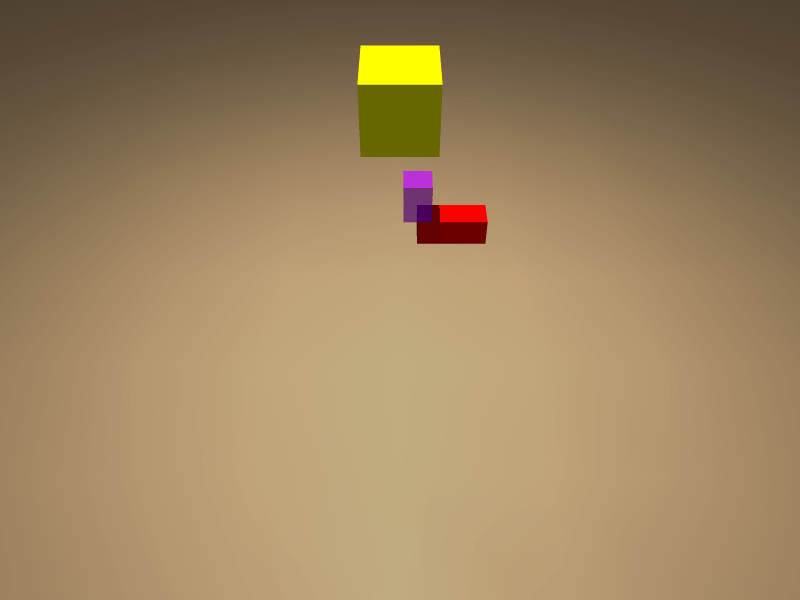

In [26]:
t,xy, frames = run_sim(stiff, damp,render=True)


In running the test I could see that the block does not go very high and to check the height it reached I simply plotted the z data with respect to time. and found that it only rose 0.08ish meters off of the ground 

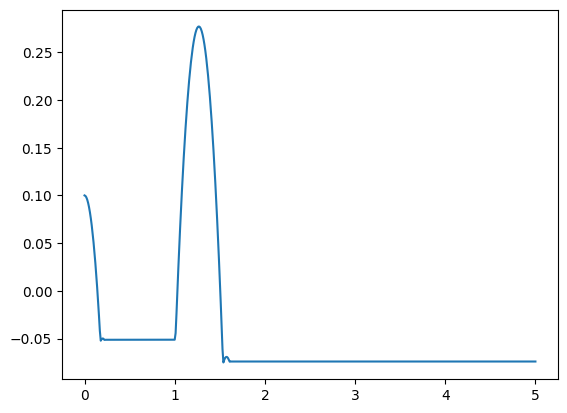

In [27]:
plt.plot(t,xy[:,2,2])

### 1. Sweep through leg stiffness from 1e-3 to 1e1 and plot max height as function of k

To complete this step I created a list of z values and k values in advance, and created another arrayfrom -3 to 1 with and interval of 0.1. Next, I made a for loop to run through each step of size 0.1 within the list exps, next I created a k and b to represent what k and b would be at the exp value that corresponds to the current step in the list. I appended the ks list with the current k value, and finally ran the simulation with these k and b values. After the simulation ran, I found the max z value by taking the z vaue in every row on the z axis and utilizing the provided .max() function to find the largest z value in the list for this k and b. I then print the z value for reference later and append the zs list with the max z value. This whole thing runs over and over until each simulation is run from -e to 1 with step sizes of 0.1; so 40 times.

In [28]:
zs = []
ks = []
exps = numpy.r_[-3:1:.1]
for exp in exps:
    k = 10**(float(exp))
    ks.append(k)
    b = k/100
    t,xy,frames = run_sim(k,b,render=False)
    max_z = xy[:,2,2].max()
    #print(max_z)
    zs.append(max_z)

To complete this question I just had to plot the values of the ks and zs to visualize each maximum height in reference to the corresponding stiffness value. plt.semilogx is used to scale the x axis(k axis) of the plot to log format. I used markers to display each step in the for loop/each individual k and z value. 

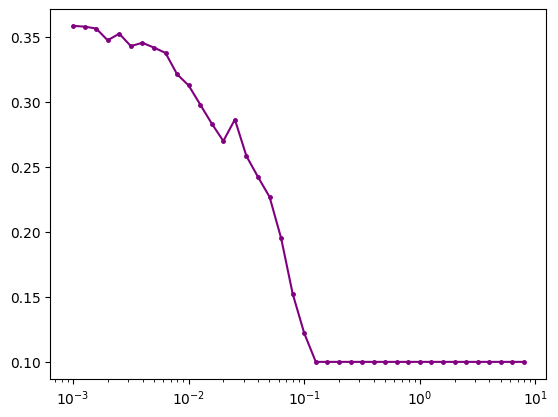

In [29]:
mainplot = plt.semilogx(ks,zs, marker = ".",
            markersize = 5,
            color = "purple")


Below is the video of the max height attained without breaking the simulation.

""

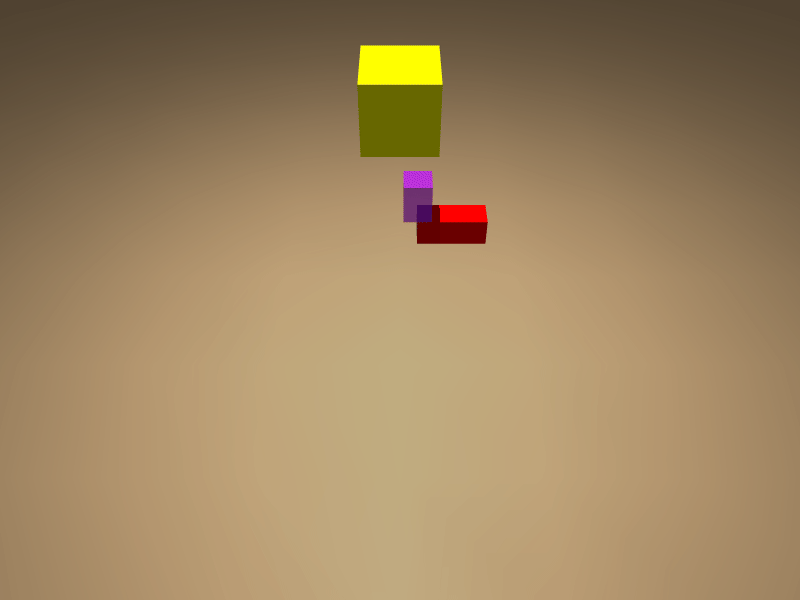

In [30]:
t, xy, frames=run_sim(2*10**-2, 2*10**-2/100,render=True)

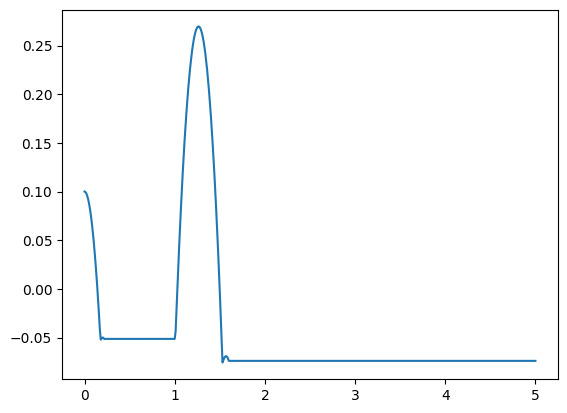

In [31]:
plt.plot(t,xy[:,2,2])

In [32]:
iis = numpy.r_[0:100:1]
for i in iis:
    if i < len(zs):
        print(zs[i])



0.35820746081449084
0.3576366340696874
0.3561750749100365
0.34713318145864874
0.3522463036396063
0.3426671038830158
0.3452074780057913
0.3415074008340581
0.33743230730138607
0.321041495879792
0.31243468707084254
0.29777351789068907
0.2831185976737154
0.2697146521186612
0.2862343150565805
0.2581273369403852
0.24208133661109169
0.22679090390606577
0.19505261757579806
0.1522951192065783
0.12197114040786056
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1


Due to the simulation break in the final 4 data points, I will truncate the list so that it only includes the datapoints that have reliable maximum heights.

In [33]:
del ks[370:]
del zs[370:]
print(ks)

[0.001, 0.0012589254117941675, 0.001584893192461114, 0.0019952623149688807, 0.002511886431509582, 0.0031622776601683824, 0.003981071705534978, 0.00501187233627273, 0.006309573444801942, 0.00794328234724283, 0.010000000000000021, 0.012589254117941701, 0.015848931924611172, 0.01995262314968885, 0.025118864315095874, 0.03162277660168389, 0.03981071705534985, 0.0501187233627274, 0.06309573444801955, 0.07943282347242846, 0.10000000000000041, 0.12589254117941726, 0.15848931924611206, 0.1995262314968889, 0.25118864315095923, 0.31622776601683955, 0.39810717055349937, 0.501187233627275, 0.6309573444801969, 0.7943282347242863, 1.0000000000000062, 1.2589254117941753, 1.5848931924611238, 1.995262314968893, 2.5118864315095975, 3.162277660168402, 3.981071705535002, 5.011872336272761, 6.309573444801981, 7.943282347242878]


In [34]:
import scipy.optimize as optimize
import numpy as np

DaZs = zs
def max_k():
    maxp = 0
    def objective_function(zVal):
        return -zVal
    
    result = optimize.minimize_scalar(objective_function, bounds=(min(DaZs), max(DaZs)), method='bounded')
    #print(result.x)
    allks = numpy.r_[0:370:1]
    for kp in allks:
        #display(kp, round(result.x, 4) , round(zs[kp],4))
        if kp < len(zs):
            if round(result.x,4) == round(zs[kp],4):
                #print("RIGHT HEREEE")
                maxp = kp
    return maxp

maxPoint = max_k()

print("Optimal Index:",maxPoint)
print("Optimal Stiffness:",ks[maxPoint])
print("Max Height:",zs[maxPoint])

Optimal Index: 0
Optimal Stiffness: 0.001
Max Height: 0.35820746081449084


Above I wrote a function that takes the list of zs and performs a minimize function that makes all the zs negative so it finds the smallest(largest) z value. Then to find the index of that value in k and returned that value. Finally I printed the index, the value of k at that index, and the value of z at that index. Now I had the highest height that the box went for the optimal k value.

To plot the point on the origional plot, I simply plotted it again and added the new found optimal stiffness point. The optimal point is in red

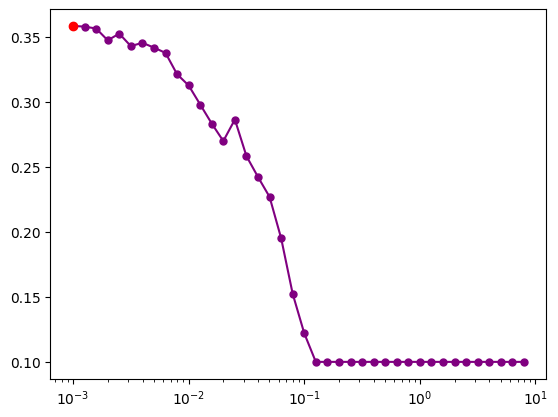

In [35]:
plt.semilogx(ks,zs, marker = ".",
            markersize = 10,
            color = "purple")
plt.plot(ks[maxPoint],zs[maxPoint], "or")

Here is the video of the optimal jump.

ValueError: Error: engine error: Python exception raised

""

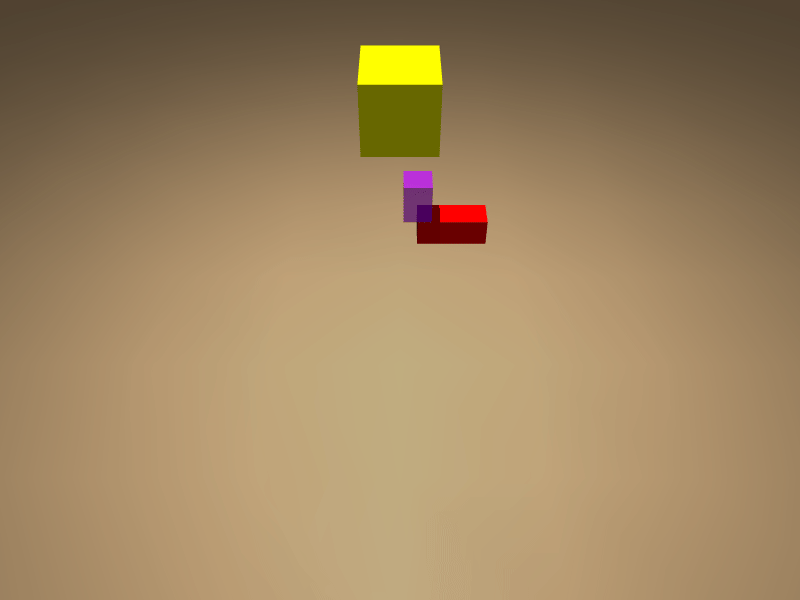

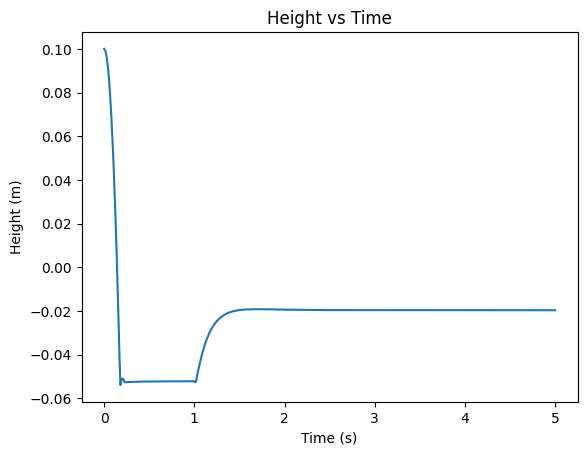

In [36]:
t,xy, frames = run_sim(ks[maxPoint], ks[maxPoint]/100,render=True)

Here is the graph of the height graph for the optimal jump

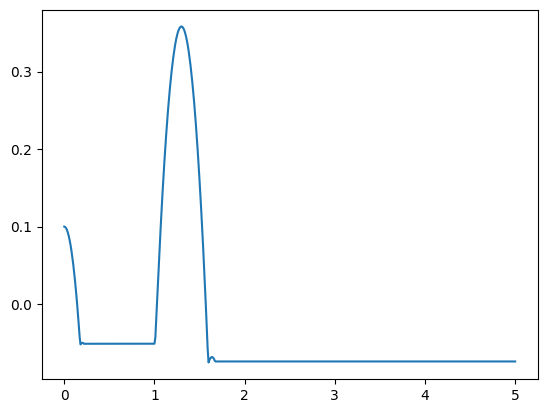

In [ ]:
plt.plot(t,xy[:,2,2])